<a href="https://colab.research.google.com/github/shalabs/Analyzing-activity-in-mouse-brain/blob/main/exploring_mouse_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Exploration.

**The dataset look at the day/night variation of protein expression in certain neurons of mice.** 


Contents:

1- Load the data

2- Plot how mean intensity varies over time

3- Compute periods numerically

4- Take a closer look at the subregions



Resource:

Peter Grenholm https://www.kaggle.com/toregil




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/dataset.zip" -d "/content/drive/My Drive/Colab Notebooks/dataset"


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
from scipy.ndimage import uniform_filter 
from sklearn.linear_model import LinearRegression


# Load Data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/data141110.csv')
df.head()

,Image.No.,Frame.No,Time.hrs.
0,40,1,3.750892
1,44,2,3.846050
2,45,3,3.946050
3,46,4,4.046050
4,47,5,4.146050


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1685 entries, 0 to 1684
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Image.No.  1685 non-null   int64  
 1   Frame.No   1685 non-null   int64  
 2   Time.hrs.  1685 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 39.6 KB


In [ ]:
data = np.loadtxt('/content/drive/My Drive/Colab Notebooks/dataset/data141110.csv', delimiter=',', skiprows=1)
image_no=data[:,0].reshape(-1,1)
frame_no=data[:,1].reshape(-1,1)
time_hrs=data[:,2].reshape(-1,1)
nb_images = data.shape[0]

In [ ]:
flo_image_1 = np.load('/content/drive/My Drive/Colab Notebooks/dataset/flo_image_1.npz')
flo_image_2 = np.load('/content/drive/My Drive/Colab Notebooks/dataset/flo_image_2.npz')
image_ids = np.concatenate([flo_image_1['image_ids'], flo_image_2['image_ids']])
images = np.concatenate([flo_image_1['image_stack'], flo_image_2['image_stack']])
del flo_image_1, flo_image_2


## Plotting one image from the dataset 

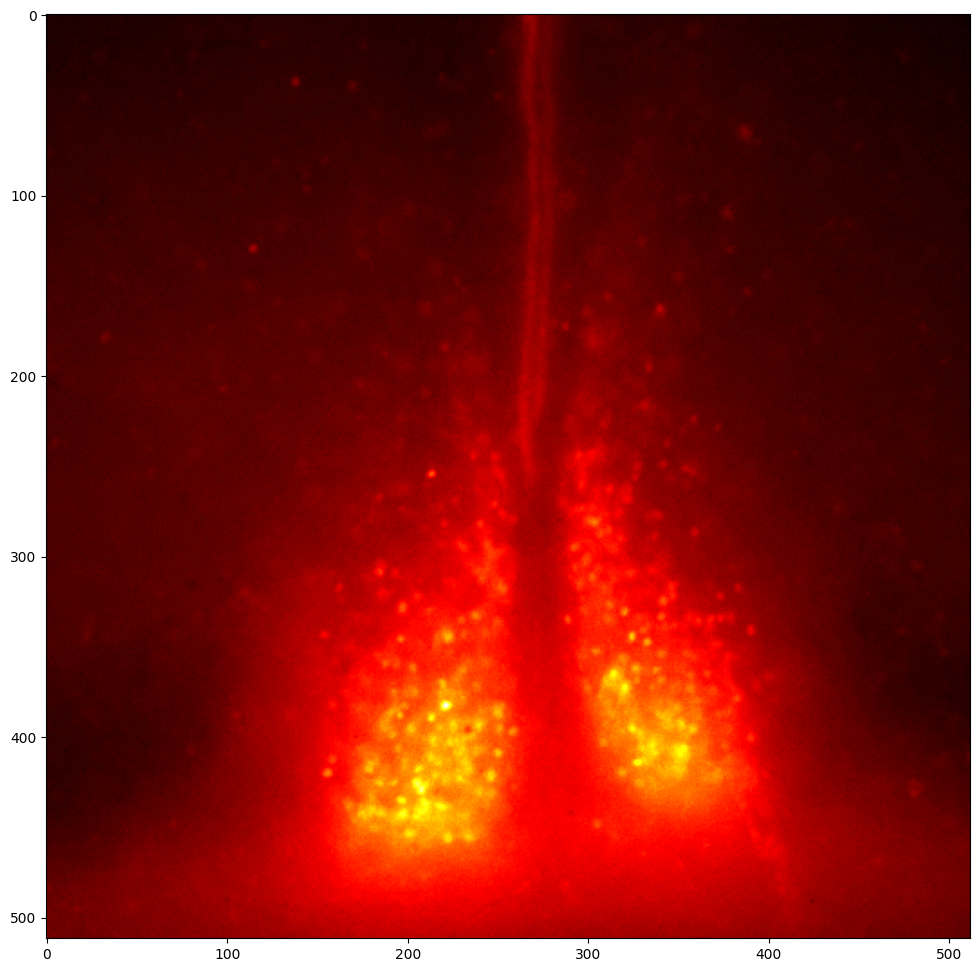

In [ ]:
fig = plt.figure(figsize = (12,12))
plt.imshow(images[121], cmap='hot')

### As can be seen in the dataset description, this is a section of mouse brain. At the bottom is the optic nerve (cannot be seen). The two bright ovals are the suprachiasmatic nuclei and the vertical line at the top is the third ventricle. The light corresponds to a certain protein whose expression varies over the day/night cycle, and our goal is to characterize this variation over time.

# Plotting intensity over time

#### Now we take the mean intensity over the whole image and plot it against time

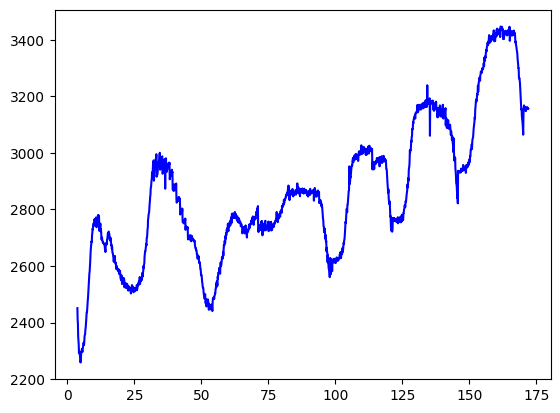

In [ ]:
mean_values = np.mean(images, axis=(1,2))
plt.plot(df['Time.hrs.'], mean_values, 'b')


### Plot shows that there is a linear trend towards higher values late in the week. To estimate this part, we use linear regression.

In [ ]:
df['Time.hrs.']

0         3.750892
1         3.846050
2         3.946050
3         4.046050
4         4.146050
           ...    
1680    171.616306
1681    171.716306
1682    171.816306
1683    171.916306
1684    172.016306
Name: Time.hrs., Length: 1685, dtype: float64

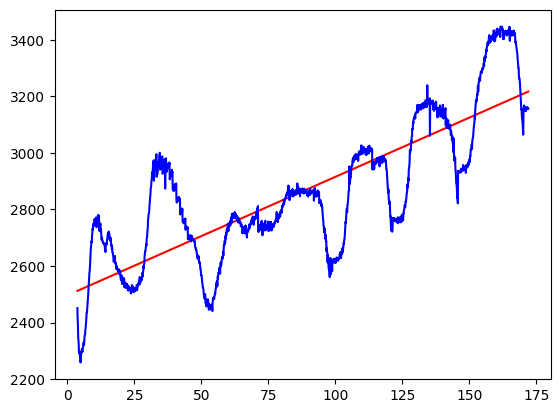

In [ ]:
model = LinearRegression()
model.fit(time_hrs, mean_values)
plt.plot(time_hrs, model.predict(time_hrs), 'r')
plt.plot(time_hrs, mean_values, 'b')

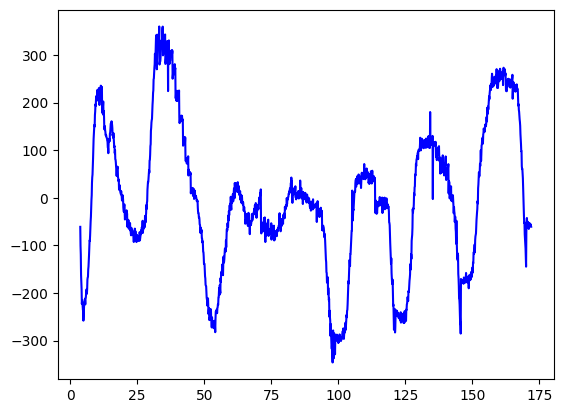

In [ ]:
mean_linear = model.predict(time_hrs)
norm_values = mean_values - mean_linear
plt.plot(time_hrs, norm_values, 'b')

We see that the overall shape is periodic, but the graph also suggests a discontinuity in the data at 40 hours and 75 hours. We cannot really tell what happens there, but for a more detailed analysis it might be a good idea to analyse time < 40, and time > 75 separately. In this notebook, we will just apply a high pass filter when needed.


The linear regression is collected in a function for later use.



In [ ]:
def remove_linear_trend(time_series):
    x_axis = np.arange(len(time_series)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_axis, time_series)
    return time_series - model.predict(x_axis)

# Compute the periods

#### A fast way to get the dominant period is the Fast Fourier Transform FFT: just take the frequency that gives the maximum value in the graph below:

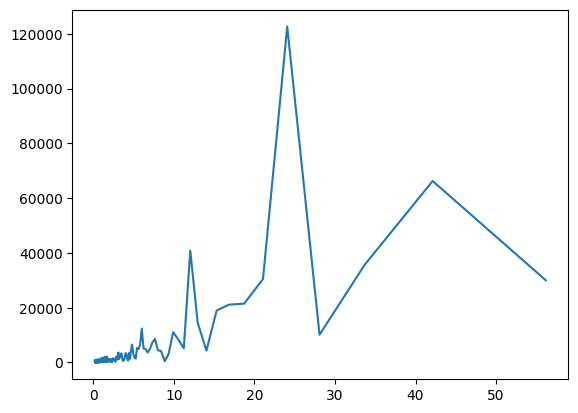

In [ ]:
spectrum = np.fft.rfft(norm_values)
freq = np.fft.rfftfreq(len(norm_values), 1/10.)  #because there are ten image frames per hour
plt.plot(1.0 / freq[3:], abs(spectrum[3:len(freq)]))

This is however only approximate: we cannot this easily tell if the period is really 24 hrs or, say, 23 hours. Autocorrelation gives a more exact answer, here also showing a peak at 24 hours.

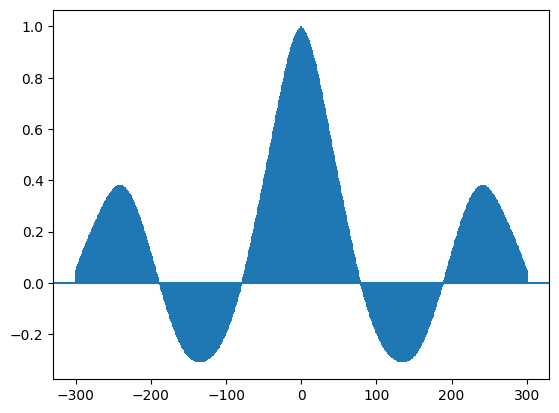

In [ ]:
acorr = plt.acorr(norm_values, maxlags=300)


Getting a more exact value for the period would be nice, in fact, this is possible if we combine the two methods and compute autocorrelation with the fft:

In [ ]:
def filtered_acorr(time_series, high_pass=None, unbiased=True):
    """
    high_pass is a short 1D float array, 
    by which the low-frequency amplitudes are multiplied,
    e.g. high_pass = [0,0,0,0,0,0]
    """
    N = len(time_series)
    norm_values = remove_linear_trend(time_series)
    spectrum = np.fft.fft(norm_values, n=2*N)
    if high_pass is not None:
        spectrum[0] *= high_pass[0]
        for i in range(len(high_pass)):
            spectrum[i] *= high_pass[i]
            spectrum[-i] *= high_pass[i]
    acorr = np.real(np.fft.ifft(spectrum * np.conj(spectrum))[:N])
    if unbiased:
        return acorr / (N - np.arange(N))
    else:
        return acorr / N

In [ ]:
def get_period(acorr):
    """
    Returns the index with largest acorr value, 
    after the first zero crossing.
    There are of course more sophisticated methods of doing this.
    """
    negative_periods = np.where(acorr <= 0.0)
    if negative_periods[0].size == 0:
        return 0
    first_zero = np.min(negative_periods)
    return first_zero + np.argmax(acorr[first_zero:])

In [ ]:
print(get_period(filtered_acorr(mean_values)[:300]))


243


This means that the dominant period for the whole dataset is 24.3 hours.



# Compare the smaller regions:

### We now divide the area into smaller squares to see what the local period is.



In [ ]:
def get_grid_periods(images, box_size, max_period=300, high_pass=np.zeros((10,)), unbiased=False):
    """
    periods, acorrs = get_grid_periods(images, box_size, max_period=300, 
                                    high_pass=np.zeros((10,)), unbiased=False)
    Divides the image domain into small boxes of size box_size = (h,w) and computes
    the period over each of these small boxes."""
    h,w = box_size
    rows = images.shape[1] // h
    cols = images.shape[2] // w
    acorrs = np.empty((rows, cols, max_period), dtype = "float32")
    periods = np.empty((rows,cols, ), dtype = "int")
    for i in range(rows):
        for j in range(cols):
            time_series = np.mean(images[:, i*h:(i+1)*h, j*w:(j+1)*w], axis=(1,2))
            acorrs[i ,j] = filtered_acorr(time_series, high_pass = high_pass, 
                                          unbiased=unbiased)[:max_period]
            periods[i ,j] = get_period(acorrs[i, j])
    return periods, acorrs


[[248 248 248 246 245 245 242 237 235 238 243 243 243 244 244 245]
 [247 247 246 246 246 244 243 238 235 240 243 243 243 244 245 245]
 [248 248 247 247 246 245 245 241 235 240 243 244 243 244 245 245]
 [247 248 247 246 245 245 245 242 233 241 243 243 244 245 245 245]
 [245 247 248 246 245 246 246 243 235 241 243 244 244 245 244 245]
 [245 247 246 245 243 246 247 244 235 243 243 244 244 244 244 245]
 [245 245 243 245 246 246 247 245 235 243 242 245 245 245 244 245]
 [247 247 245 245 247 247 246 245 240 241 243 244 245 245 244 244]
 [246 248 246 246 247 247 243 243 246 238 242 245 245 245 245 245]
 [248 248 247 247 246 245 239 237 242 236 235 243 243 245 245 245]
 [248 248 245 243 244 243 235 236 240 235 232 237 243 245 245 245]
 [248 247 248 245 244 238 232 231 237 230 226 230 241 245 245 245]
 [248 246 248 245 243 231 231 232 236 234 226 224 237 243 243 243]
 [248 246 245 243 240 226 227 234 237 236 233 226 231 239 241 242]
 [245 243 243 240 235 228 231 236 238 238 237 237 236 240 241 

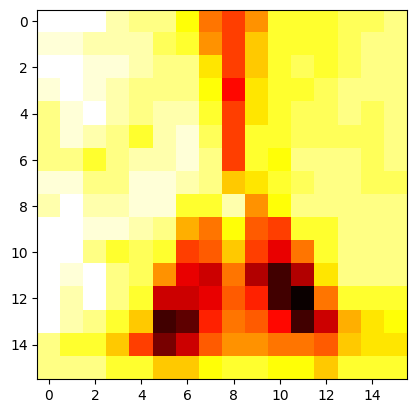

In [ ]:
periods, acorrs = get_grid_periods(images, (32, 32), max_period=1000, unbiased=False)
plt.imshow(periods, cmap='hot')
print(periods)

This suggests that the period is slightly smaller (around 23 hours), in the center of the two bright nuclei, and close to 25 hours at the periphery. I am not sure that this is true, for several reasons:

1. It doesn't really make much sense that light-sensitive neurons in a realistic setting vary in anything else than 24 hours. Over time, this would cause them to be completely out of phase with the day/night cycle.


 2. As will be seen in the section below, there is still much noise/artifact in the data which would confuse our simple functions, even with the filters on.


#### We also collected the autocorrelations for subregions. Looking at a few of them, we see that they vary greatly in amplitude, but the period seems to be correct.

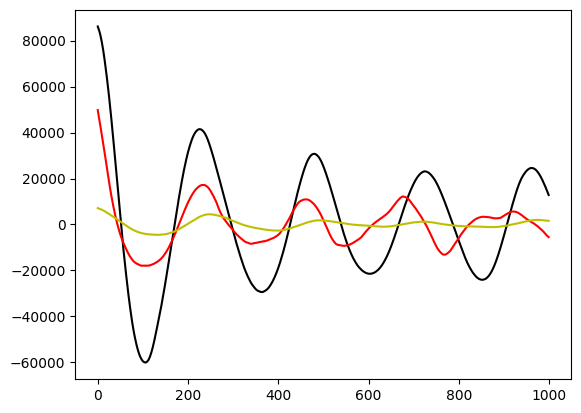

In [ ]:
plt.plot(acorrs[13,5], color ='k')
plt.plot(acorrs[3,8], color='r')
plt.plot(acorrs[5,1], color='y')

The results above suggest that all regions have period close to 24 hours. We can now look at some images separated by 12 hours and see if the light intensity varies as expected:

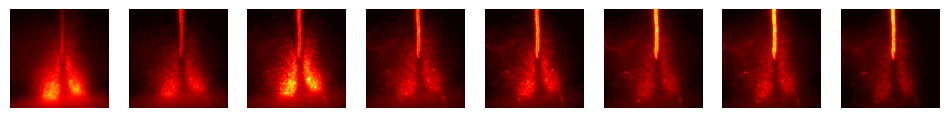

In [ ]:
fix, ax = plt.subplots(1,8, figsize=(12,4))
idx = [80, 200, 320, 440, 560, 740, 860, 980]
for j in range(8):
    ax[j].set_axis_off()
    ax[j].imshow(images[idx[j],:,:] - mean_linear[idx[j]], cmap='hot', vmin=-800, vmax=6400)

This does indeed show some day/night variation, but it also shows how the vertical line in the middle becomes gradually more intense, maybe explaining the linear trend we subtracted previously. This can be seen more clearly if we instead select time frames corresponding to daylight:

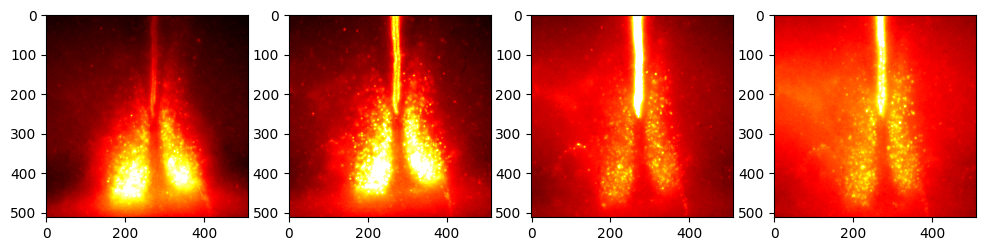

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(12,12))
ax[0].imshow(images[100], cmap='hot', vmin=1500, vmax=6000)
ax[1].imshow(images[320], cmap='hot', vmin=1500, vmax=6000)
ax[2].imshow(images[1050], cmap='hot', vmin=1500, vmax=6000)
ax[3].imshow(images[1530], cmap='hot', vmin=1500, vmax=6000)

I would guess that these slower changes have technical reasons such as diffusion/excretion of a contrast agent.

In [ ]:
image_dict = dict(zip(image_ids, images))

In [ ]:
time_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/data141110.csv')
time_df['path'] = time_df['Image.No.'].map(lambda x: "141110A3.%04d" % (x))
time_df['loaded'] = time_df['path'].map(lambda x: x in image_dict)
valid_time_df = time_df.query('loaded')
valid_time_df.sample(3)

,Image.No.,Frame.No,Time.hrs.,path,loaded
296,346,297,33.216306,141110A3.0346,True
478,528,479,51.416306,141110A3.0528,True
677,727,678,71.316306,141110A3.0727,True


In [ ]:
ordered_im_stack = np.stack([image_dict[c_path] for c_path in valid_time_df.sort_values('Time.hrs.')['path'].values],0)

In [ ]:
# unwrap the pixel positions so we have just the time observations
time_vec = ordered_im_stack.reshape(ordered_im_stack.shape[0], -1)

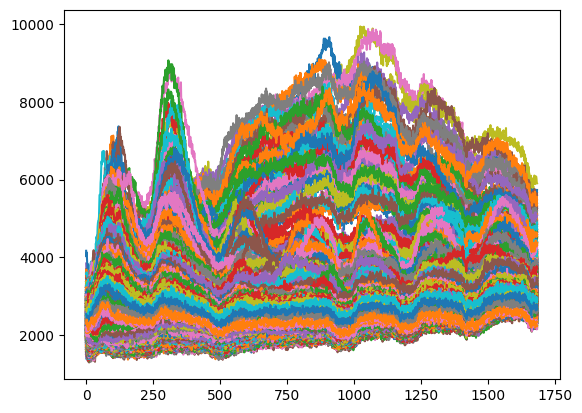

In [ ]:
# show the various time courses
_ = plt.plot(time_vec[:,::100])

# K-Means Clustering

Here we cluster the temporal data by time to make a better representation of the image



In [ ]:
from sklearn.cluster import KMeans
n_kmc = KMeans(n_clusters = 6)

In [ ]:
%%time
# apply the kmeans clustering
n_kmc.fit(time_vec.T)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 30min 15s, sys: 12.5 s, total: 30min 27s
Wall time: 18min 22s


KMeans(n_clusters=6)

Next we show the clusters as a new image, the regions colored the same, have the same time-course of activation and thus fire together.

Text(0.5, 1.0, 'Cluster Image')

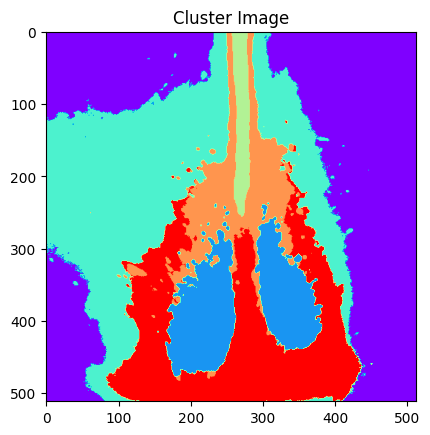

In [ ]:

cluster_vec = n_kmc.predict(time_vec.T)
cluster_img = cluster_vec.reshape(ordered_im_stack.shape[1:])
fig, ax1 = plt.subplots(1,1)
ax1.imshow(cluster_img, cmap = 'rainbow')
ax1.set_title('Cluster Image')

## Time Behavior of Each Cluster

Here we take each cluster and show the temporal behavior. This lets us show more clearly the differences between groups and see if there are groups which are phase-shifted from others which might indicate a sequential firing pattern

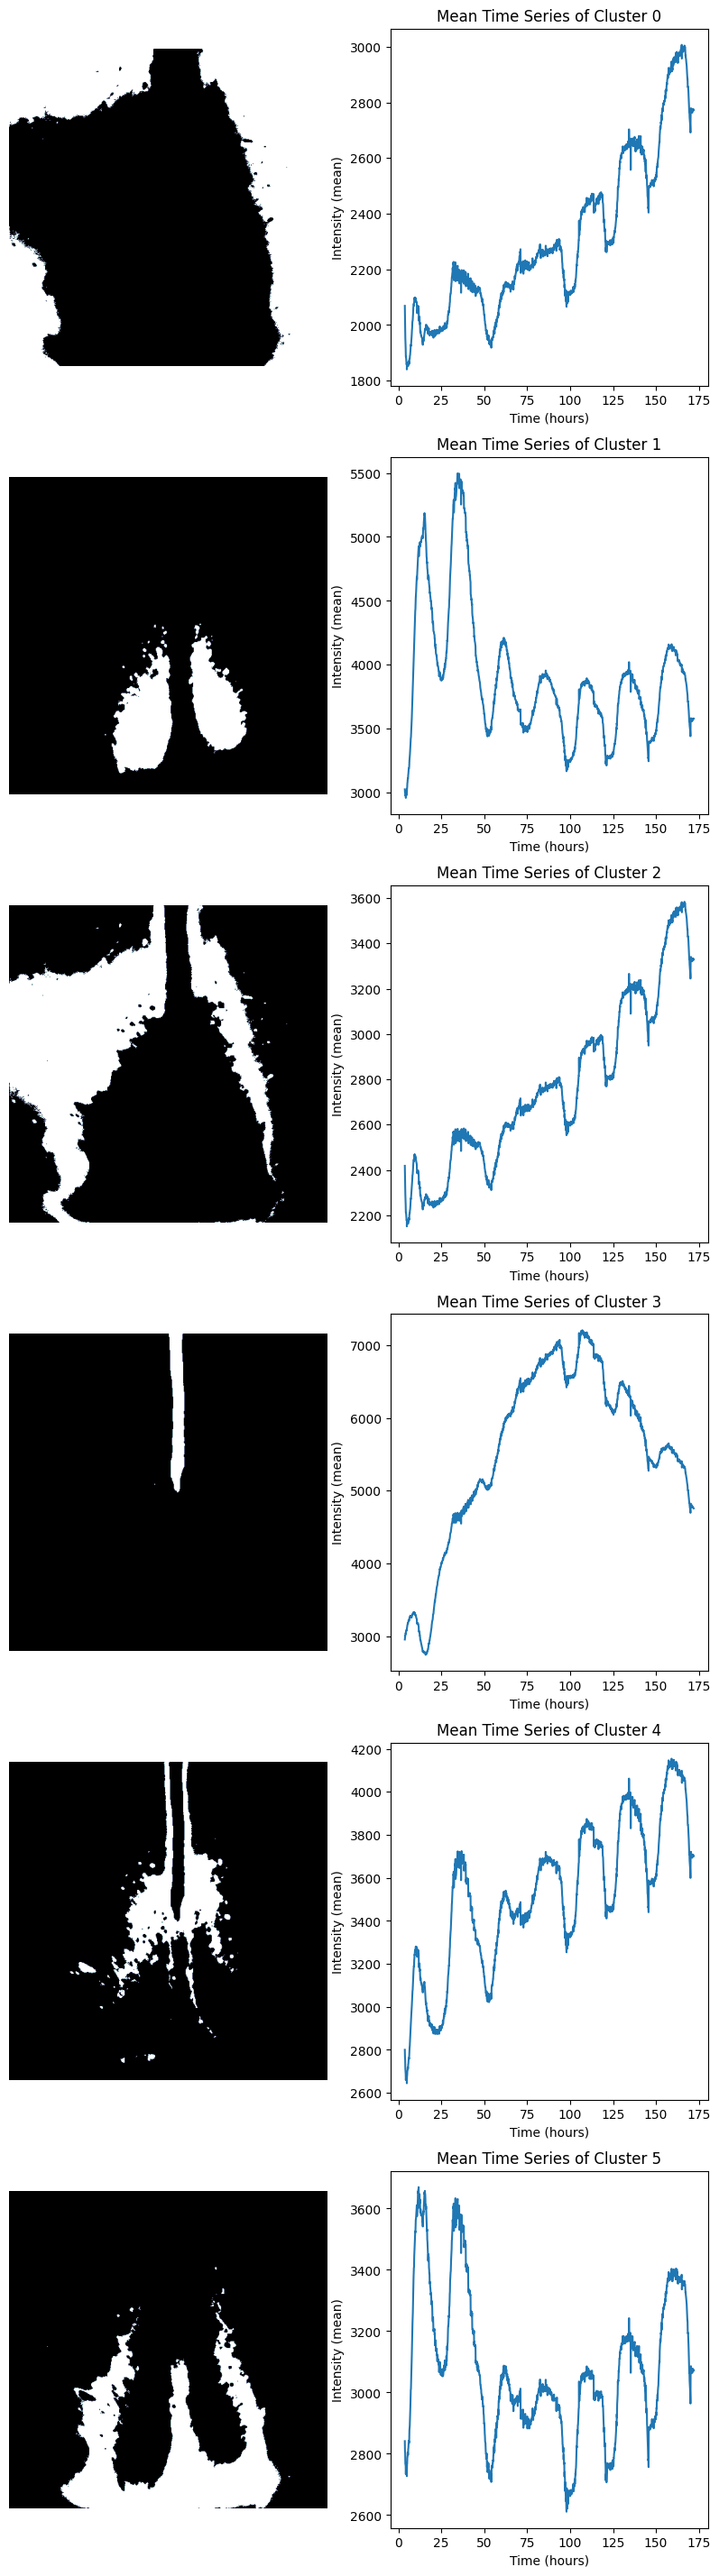

In [ ]:
cluster_ids = np.unique(cluster_vec)
fig, m_axs = plt.subplots(len(cluster_ids), 2, figsize = (10, len(cluster_ids)*6))
for (im_ax, c_ax) , idx in zip(m_axs, cluster_ids):
    im_ax.imshow(cluster_img == idx, cmap = 'bone')
    im_ax.axis('off')
    c_ax.set_title('Image of Cluster {}'.format(idx))
    c_ax.plot(
        valid_time_df['Time.hrs.'],
        np.mean(time_vec[:,cluster_vec == idx],1))
    c_ax.set_title('Mean Time Series of Cluster {}'.format(idx))
    c_ax.set_xlabel('Time (hours)')
    c_ax.set_ylabel('Intensity (mean)')